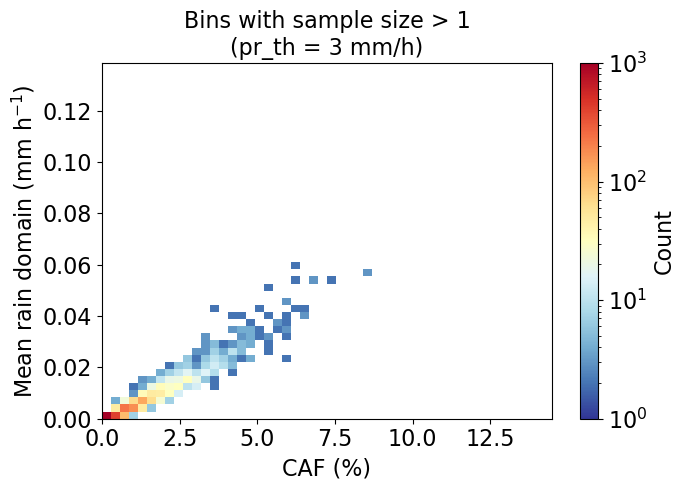

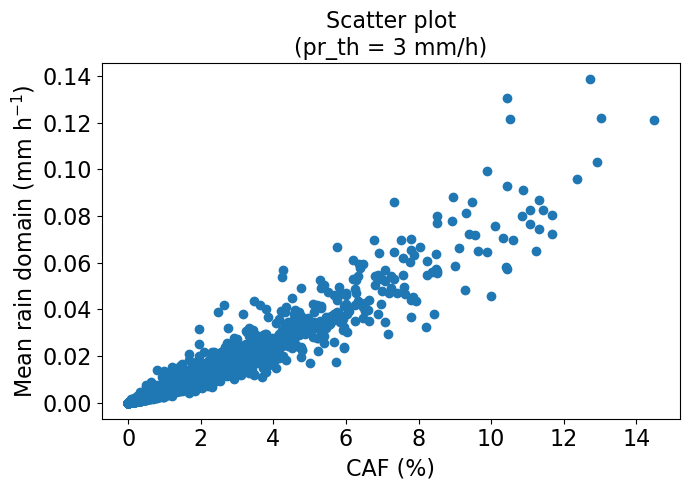

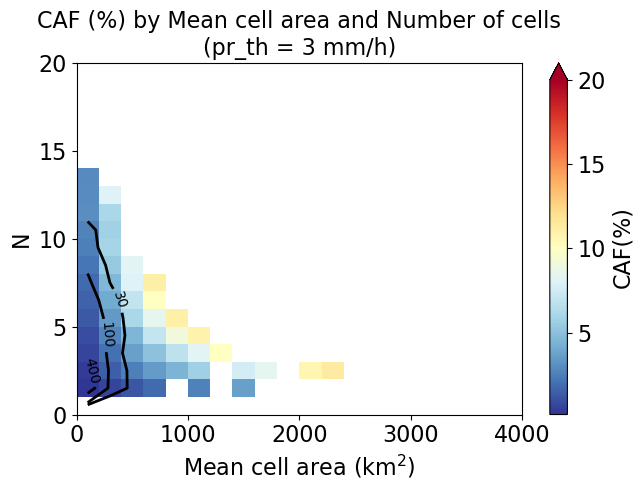

In [16]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.stats import binned_statistic_2d
import os

# ======= Set manually =======
country = "Germany"  # or "UK"
# ============================

th_i = 3
xbins, ybins = 20, 20
xrange = [0, 4000]
yrange = [0, 20]
vmax = 20
min_count = 1

## matplotlib parameters to make my life easier
params = {     
    'axes.labelsize': '16',   
    'axes.titlesize': '16',  
    'xtick.labelsize': '16',
    'ytick.labelsize': '16',    
    'lines.linewidth': '2',   
    'legend.fontsize': '12', 
    'figure.figsize': '9, 7'    
}
plt.rcParams.update(params)

# Define thresholds
pr_th_list = [0.5, 1, 2, 3, 4, 5]
pr_th = pr_th_list[th_i]

# Use country variable in paths
output_path = f"/scratch/nf33/hk25_LSP/{country}/Darwin/number_size_prth_{pr_th}_hourly.nc"

ds_ts = xr.open_mfdataset(output_path)

## array to store object number
num_obj_arr = ds_ts["num_obj"].where(np.isfinite(ds_ts["num_obj"]), other=np.nan)
## array for total area
tot_area_arr = ds_ts["tot_area"].where(np.isfinite(ds_ts["tot_area"]), other=np.nan)
## array to store mean cell size
mean_obj_area_arr = ds_ts["mean_obj_area"].where(np.isfinite(ds_ts["mean_obj_area"]), other=np.nan)
## array to store convective area fraction
area_frac_arr = ds_ts["area_frac"].where(np.isfinite(ds_ts["area_frac"]), other=np.nan) * 100
## mean precipitation over convective area
cvt_mean_prcp_arr = ds_ts["cvt_mean_prcp"].where(np.isfinite(ds_ts["cvt_mean_prcp"]), other=np.nan)
## mean precipitation over the entire radar scan
tot_mean_prcp_arr = ds_ts["tot_mean_prcp"].where(np.isfinite(ds_ts["tot_mean_prcp"]), other=np.nan)
## total convective precipitation
cvt_tot_prcp_arr = ds_ts["cvt_tot_prcp"].where(np.isfinite(ds_ts["cvt_tot_prcp"]), other=np.nan)

# Ensure plot folder exists
os.makedirs("/home/565/yl8842/hk25-AusNode-LargeScaleP/work_folder/plot", exist_ok=True)

# === First figure: 2D histogram ===
x = area_frac_arr
y = tot_mean_prcp_arr

counts, xedges, yedges = np.histogram2d(
    x, y,
    bins=50,
    range=[[x.min(), x.max()], [y.min(), y.max()]]
)

counts_masked = np.where(counts > min_count, counts, np.nan)
X, Y = np.meshgrid(xedges, yedges)

plt.figure(figsize=(7, 5))
pcm = plt.pcolormesh(
    X, Y, counts_masked.T,
    norm=LogNorm(vmin=1, vmax=1000),
    cmap='RdYlBu_r',
    shading='auto'
)
plt.colorbar(pcm, label="Count")
plt.xlabel("CAF (%)")
plt.ylabel("Mean rain domain (mm h$^{-1}$)")
plt.title(f"Bins with sample size > {min_count}\n(pr_th = {pr_th} mm/h)")
plt.tight_layout()
plt.show()

# === Second figure: Scatter plot ===
plt.figure(figsize=(7, 5))
plt.scatter(x, y)
plt.xlabel("CAF (%)")
plt.ylabel("Mean rain domain (mm h$^{-1}$)")
plt.title(f"Scatter plot\n(pr_th = {pr_th} mm/h)")
plt.tight_layout()
plt.show()

# === Third figure: 2D binned statistic plot ===
x = mean_obj_area_arr.values
y = num_obj_arr.values
z = area_frac_arr.values

mask = np.isfinite(x) & np.isfinite(y) & np.isfinite(z)
x2, y2, z2 = x[mask], y[mask], z[mask]

stat, xedges, yedges, _ = binned_statistic_2d(
    x2, y2, z2,
    statistic='mean',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

counts, _, _, _ = binned_statistic_2d(
    x2, y2, None, statistic='count',
    bins=[xbins, ybins],
    range=[xrange, yrange]
)

stat[counts <= 1] = np.nan
X, Y = np.meshgrid(xedges, yedges, indexing='xy')

x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2

fig, ax = plt.subplots(figsize=(7, 5))
pcm = ax.pcolormesh(
    X, Y, stat.T,
    cmap='RdYlBu_r',
    shading='auto', vmax=vmax,
)
fig.colorbar(pcm, ax=ax, label="CAF(%)", extend="max")
cs = ax.contour(x_centers, y_centers, counts.T, levels=[30, 100, 400], colors="k")
ax.clabel(cs, inline=True, fontsize=10, fmt="%.0f")
ax.set_xlabel("Mean cell area (km$^2$)")
ax.set_ylabel('N')
ax.set_title(f"CAF (%) by Mean cell area and Number of cells\n(pr_th = {pr_th} mm/h)")
plt.tight_layout()

# Save the last figure using country in filename and your specified path
fig.savefig(f"/home/565/yl8842/hk25-AusNode-LargeScaleP/work_folder/plot/{country}_caf_mean_cellarea_number_prth_{pr_th}mmh.png", dpi=300)
plt.show()
